In [1]:
import torch
import torch.backends.cudnn

gpu = torch.device('cuda')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # Replace "0" with the index of the GPU you want to use (e.g., "0" for the first GPU).

In [3]:
def ctcloss_reference(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='mean'):
    input_lengths = torch.as_tensor(input_lengths, dtype=torch.long)
    target_lengths = torch.as_tensor(target_lengths, dtype=torch.long)
    dt = log_probs.dtype
    log_probs = log_probs.double()  # we need the accuracy as we are not in logspace
    targets = targets.long()
    cum_target_lengths = target_lengths.cumsum(0)
    losses = []
    for i in range(log_probs.size(1)):
        input_length = input_lengths[i].item()
        target_length = target_lengths[i].item()
        cum_target_length = cum_target_lengths[i].item()
        # ==========================================================================================================
        targets_prime = targets.new_full((2 * target_length + 1,), blank)
        if targets.dim() == 2:
            targets_prime[1::2] = targets[i, :target_length]
        else:
            targets_prime[1::2] = targets[cum_target_length - target_length:cum_target_length]
        # ==========================================================================================================
        probs = log_probs[:input_length, i].exp()
        # ==========================================================================================================
        alpha = log_probs.new_zeros((target_length * 2 + 1,))
        alpha[0] = probs[0, blank]
        alpha[1] = probs[0, targets_prime[1]]
        mask_third = (targets_prime[:-2] != targets_prime[2:])
        for t in range(1, input_length):
            alpha_next = alpha.clone()
            alpha_next[1:] += alpha[:-1]
            alpha_next[2:] += torch.where(mask_third, alpha[:-2], alpha.new_zeros(1))
            alpha = probs[t, targets_prime] * alpha_next
        # ==========================================================================================================
        losses.append(-alpha[-2:].sum().log()[None])
    output = torch.cat(losses, 0)
    if reduction == 'mean':
        return (output / target_lengths.to(dtype=output.dtype, device=output.device)).mean()
    elif reduction == 'sum':
        return output.sum()
    output = output.to(dt)
    return output


In [3]:
import torch.nn as nn
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Forward pass
        out = self.linear(x).log_softmax(2)
        return out

In [4]:
target_lengths = torch.tensor([8, 8, 8]).cuda()
input_lengths =  torch.tensor([10, 10, 10]).cuda()
targets = torch.randint(1, 15, (sum(target_lengths),), dtype=torch.int).cuda()
# input     = torch.nn.Parameter(torch.randn(50,3,40).cuda(),requires_grad=True)
# weight    = torch.nn.Parameter(torch.randn(40,15).cuda(),  requires_grad=True)
asr_model = LinearModel(40,15).cuda()
grad_match= torch.zeros(15,40).cuda()

# ctc_pt_loss = torch.nn.CTCLoss()

In [5]:
torch.backends.cudnn.enabled = True

def meta_loss(logits, targets, input_lengths, target_lengths, grad_to_match, model_w):
    ctc_loss =  ctcloss_reference(logits, targets.cuda(), input_lengths, target_lengths).float()
    # ctc_loss =  ctc_pt_loss(logits, targets, input_lengths, target_lengths).float()
    dl_dw    =  torch.autograd.grad(ctc_loss, model_w , allow_unused=True, create_graph=True)
    mse_loss = ((dl_dw[0]-grad_match)**2).sum()
    return mse_loss

lr = 1
input_     = torch.nn.Parameter(torch.randn(50,3,40).cuda(),requires_grad=True)

loss_history = []

for i in range(100):
    logits_ = asr_model(input_) 
    m_loss_ = meta_loss(logits_, targets, input_lengths, target_lengths, grad_match, asr_model.linear.weight)
    if i%10==0: print('epoch {} loss {}'.format(i, m_loss_.item()))

    loss_history.append(m_loss_.item())
    input_grad = torch.autograd.grad(m_loss_, input_)

    input_ = input_ - lr * input_grad[0]


epoch 0 loss 1.0470930337905884
epoch 10 loss 0.8894965648651123
epoch 20 loss 0.7846360802650452
epoch 30 loss 0.6961808800697327
epoch 40 loss 0.620633602142334
epoch 50 loss 0.5556848049163818
epoch 60 loss 0.49953851103782654
epoch 70 loss 0.4507579505443573
epoch 80 loss 0.4081803560256958
epoch 90 loss 0.370856910943985


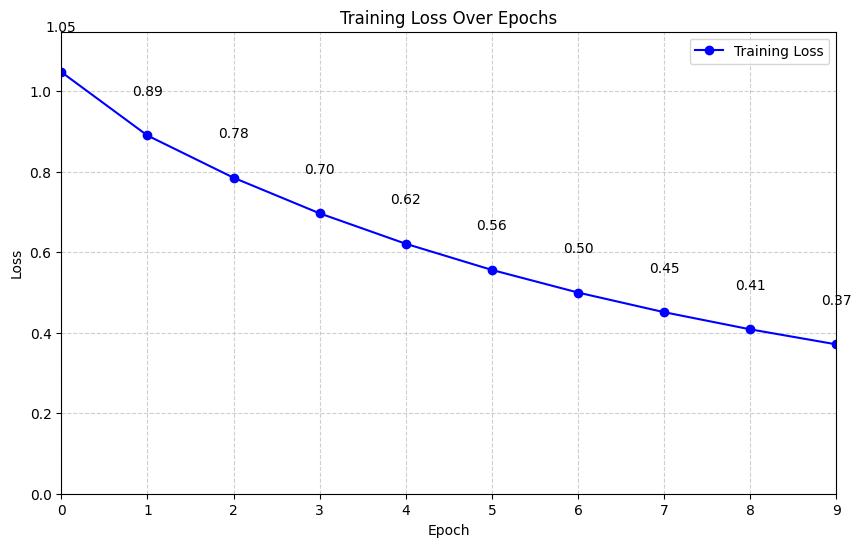

In [8]:
from utils import plot_loss_over_epochs

plot_loss_over_epochs(list(range(10)), loss_history[0:100:10])

In [13]:
loss_history

[0.3858702778816223,
 0.38537102937698364,
 0.38487306237220764,
 0.3843763768672943,
 0.3838810622692108,
 0.38338702917099,
 0.3828943967819214,
 0.38240307569503784,
 0.3819132447242737,
 0.3814247250556946,
 0.3809376358985901,
 0.380452036857605,
 0.3799678385257721,
 0.3794851005077362,
 0.3790038526058197,
 0.37852412462234497,
 0.37804585695266724,
 0.37756913900375366,
 0.3770938515663147,
 0.37662020325660706]